In [1]:
import matplotlib.pyplot as plt
from datetime import datetime


def format_data(N_hours):
    full_data = []
    for i in range(N_hours+1):
        filename = str(i) + ".txt"

        file = open(filename, 'r')

        rows = file.readlines()
        data = []
        for row in rows:
            new_data = row[0:len(row)-1].split("\t")
            new_data[0] = int(new_data[0])
            new_data[1] = datetime.fromisoformat(new_data[1][0:len(new_data[1])-1])
            new_data[2] = int(new_data[2])
            new_data[3] = float(new_data[3])
            new_data[4] = float(new_data[4])
            data.append(new_data)

        #for row in data:
        #print(len(data))
        full_data += data
        file.close()

    #full_data = full_data[0:len(full_data)]
    #print(len(full_data))
    #for i in range(44680, 44710, 1):
    #    print(full_data[i])
    return full_data

full_data = format_data(43)


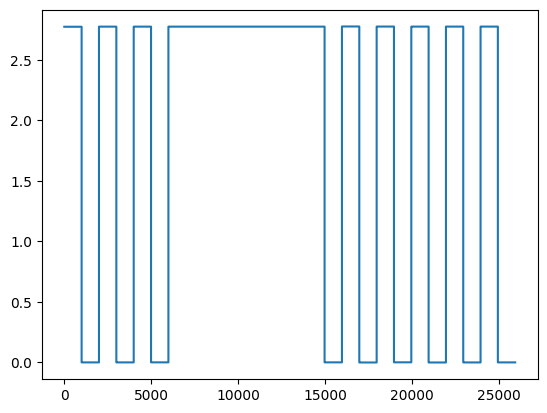

In [2]:
#Analizando el glitch en particular

glitch_data = full_data[44690:44710]

v = []
t = []
for i in range(1, len(glitch_data)):
    if i == 1:
        base_t = 0    
    else:
        base_t = t[-1]
    for j in range(base_t, base_t + glitch_data[i][2]+1):
        t.append(j)
        v.append(glitch_data[i][3])

plt.plot(t,v)
plt.show()

In [6]:
import numpy as np
#Analisis de precision del clock

#Obtain all possible Vcc values with 0.1 difference
v_list = []

for data in full_data:
    v_high = max(data[3], data[4])
    v_high = float(str(v_high)[:3])
    if not v_high in v_list:
        v_list.append(v_high)
v_list.sort(reverse=True)

#Get a list, each row is a list of ms period for that Voltage

total_period_by_v = [[]]
nominal_period_by_v = [[]]
outliers_by_v = [[]]

current_v_high = 0
for data in full_data:
    v_high = max(data[3], data[4])
    v_high = float(str(v_high)[:3])
    if v_high == current_v_high:
        total_period_by_v[-1].append(data[2])
        if abs(data[2]-1000) < 20:           #Tolerancia del 2% del valor nominal de 1000useg
            nominal_period_by_v[-1].append(data[2])
        else:
            outliers_by_v[-1].append(data[2])
    else:
        total_period_by_v.append([data[2]])
        if abs(data[2]-1000) < 20:           #Tolerancia del 2% del valor nominal de 1000useg
            nominal_period_by_v.append([data[2]])
            outliers_by_v.append([])
        else:
            nominal_period_by_v.append([])
            outliers_by_v.append([data[2]])
        current_v_high = v_high

total_period_by_v = total_period_by_v[1:]
nominal_period_by_v = nominal_period_by_v[1:]
outliers_by_v = outliers_by_v[1:]


for i in range(len(total_period_by_v)):
    print("VCC = ", v_list[i], "V")
    #print("\ttotal_period_by_v = ", total_period_by_v[i])
    #print("\tlen(total_period_by_v) = ", len(total_period_by_v[i]))
    #print("")
    #print("\tlen(nominal_period_by_v) = ", len(nominal_period_by_v[i]))
    #print("")
    print("\tMean = ", round(np.mean(nominal_period_by_v[i]), 2), "us")
    print("\tStd = ", round(np.std(nominal_period_by_v[i]), 2), "us")
    print("\tPercentage of periods within a 2% from nominal: ", round(100*len(nominal_period_by_v[i])/len(total_period_by_v[i]), 2), "%")
    #print("")
    print("\tmax, min (nominal) = ", max(nominal_period_by_v[i]), "us,", min(nominal_period_by_v[i]), "us")
    print("\tmax, min (outliers) = ", max(outliers_by_v[i]), "us,", min(outliers_by_v[i]), "us")
    #print("\toutliers_by_v = ", outliers_by_v[i])
    #print("\tlen(outliers_by_v) = ", len(outliers_by_v[i]))
    print("")
#plt.hist(total_period_by_v[1], 10000, density=False)
##plt.show(#)



VCC =  3.2 V
	Mean =  996.34 us
	Std =  1.62 us
	Percentage of periods within a 2% from nominal:  99.91 %
	max, min (nominal) =  1018 us, 985 us
	max, min (outliers) =  8761 us, 222 us

VCC =  2.9 V
	Mean =  985.82 us
	Std =  1.44 us
	Percentage of periods within a 2% from nominal:  99.85 %
	max, min (nominal) =  1018 us, 981 us
	max, min (outliers) =  1270 us, 700 us

VCC =  2.7 V
	Mean =  1003.37 us
	Std =  1.34 us
	Percentage of periods within a 2% from nominal:  98.18 %
	max, min (nominal) =  1013 us, 982 us
	max, min (outliers) =  1748 us, 259 us

VCC =  2.0 V
	Mean =  998.78 us
	Std =  1.21 us
	Percentage of periods within a 2% from nominal:  99.3 %
	max, min (nominal) =  1010 us, 990 us
	max, min (outliers) =  1459 us, 541 us



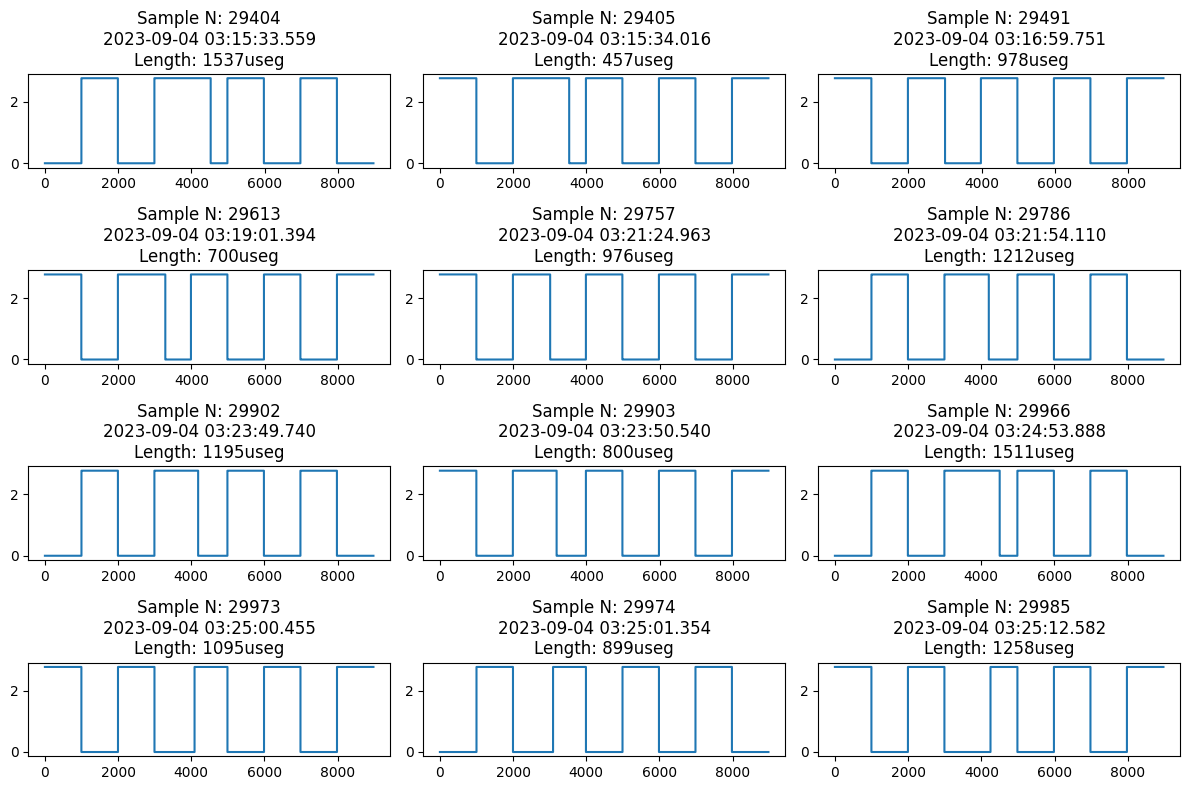

In [5]:
#Time analysis of glitches:

#Outliers is a list of lists of data points, where each list is 10 points of data, centered around an outlier
outliers = []
for i in range(len(full_data[5:-5])):
    if abs(full_data[i][2]-1000) > 20:           #Tolerancia del 2% del valor nominal de 1000useg
        outliers.append(full_data[i-4:i+6])

#Transform Outliers elements to time series data
outliers_timeseries = []
for p in range(len(outliers)):
    v = []
    t = []
    for i in range(1, len(outliers[p])):
        if i == 1:
            base_t = 0    
        else:
            base_t = t[-1]
        for j in range(base_t, base_t + outliers[p][i][2]+1):
            t.append(j)
            v.append(outliers[p][i][3])
    outliers_timeseries.append([t, v, outliers[p][4][1], outliers[p][4][0], outliers[p][4][2]])        #Now each element in outliers is a timeseries shifted to t=0, we should also add the moment when it happened, so whe add the timestamp of the outlier (number 4 in timeseries)

cols = 3
rows = 4

# Create a figure and axis objects
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))

# Create your plots and add them to the grid
for i in range(rows):
    for j in range(cols):
        # Create your plot here (e.g., using plt.plot(), plt.scatter(), etc.)
        # Example:
        axes[i, j].plot(outliers_timeseries[j+rows*i][0], outliers_timeseries[j+rows*i][1])
        axes[i, j].set_title("Sample N: " + str(outliers_timeseries[j+rows*i][3]) + "\n" + str(outliers_timeseries[j+rows*i][2])[:-3] + "\nLength: " + str(outliers_timeseries[j+rows*i][4]) + "useg")
        # You can customize the individual plots here

# Adjust layout and spacing
plt.tight_layout()

# Show or save the plot
plt.show()



Number of true outliers:  54
Number of possible glitches:  184


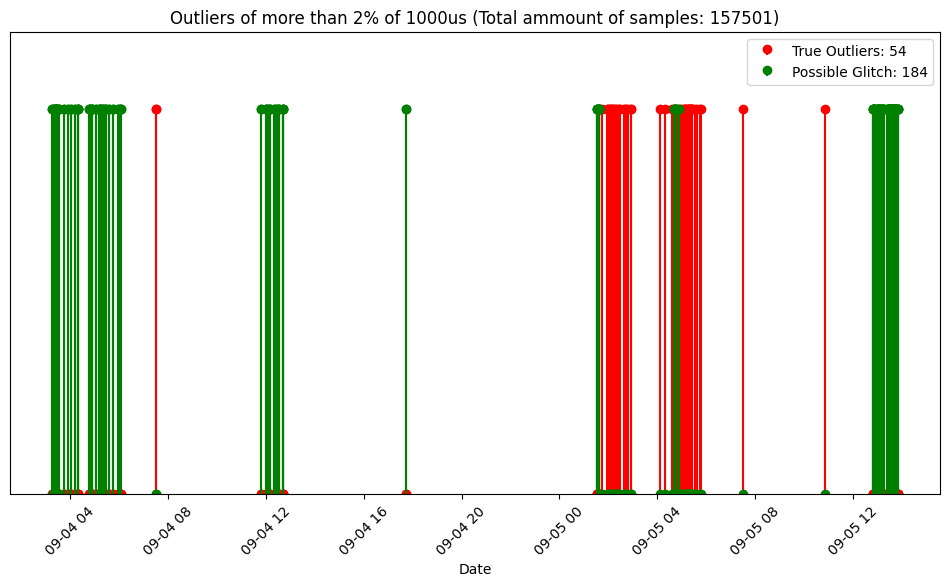

In [18]:
#Timewise plot of different outliers
dates = []
true_outlier = []
possible_glitch = []
glitch_flag = False
for i in range(len(outliers)):
    dates.append(outliers[i][4][1])
    if glitch_flag == True:
        true_outlier.append(0)
        possible_glitch.append(1)
        glitch_flag = False
    else:
        if i+1 < len(outliers):
            if outliers[i][4][0] + 1 == outliers[i+1][4][0] and ((outliers[i][4][2] + outliers[i+1][4][2])/2 - 1000 < 20):    #Subsecuent outliers with sum close to 2 times 1000useg get categorized as possible computer glitch
                true_outlier.append(0)
                possible_glitch.append(1)
                glitch_flag = True
            else:
                true_outlier.append(1)
                possible_glitch.append(0)
        else:
            true_outlier.append(1)
            possible_glitch.append(0)

print("Number of true outliers: ", true_outlier.count(1))
print("Number of possible glitches: ", possible_glitch.count(1))


# Set the figure size
plt.figure(figsize=(12, 6))  # Adjust the width and height

# Create a stem plot with labels, colors, and other settings
plt.stem(dates, true_outlier, linefmt='-r', markerfmt='or', basefmt=' ', label= "True Outliers: " + str(true_outlier.count(1)))

# Create a stem plot with labels, colors, and other settings
plt.stem(dates, possible_glitch, linefmt='-g', markerfmt='og', basefmt=' ', label= "Possible Glitch: " + str(possible_glitch.count(1)))

# Set the title, labels, and grid
plt.xlabel('Date')
plt.ylabel('Outliers')
plt.title('Outliers of more than 2% of 1000us (Total ammount of samples: ' + str(len(full_data)) + ")")

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1.2)

# Display numbers only for the x-axis
plt.gca().get_yaxis().set_visible(False)
plt.legend()
plt.show()





  



